In [74]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [75]:
# !cd /content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2.zip
# !unzip /content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2.zip

In [76]:
!pip check

ipython 7.34.0 requires jedi, which is not installed.
torch 2.6.0+cu124 has requirement nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2.
torch 2.6.0+cu124 has requirement nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82.
torch 2.6.0+cu124 has requirement nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75.
torch 2.6.0+cu124 has requirement nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux

In [77]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [78]:
# import zipfile

# zip_path = "/content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2.zip"
# extract_path = "/content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("✅ 압축 해제 완료")

In [79]:
base_path = "/content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2"
image_files = sorted([f for f in os.listdir(base_path) if f.endswith(".pgm")])
label_files = sorted([f for f in os.listdir(base_path) if f.endswith(".eye")])

In [80]:
data = []
for img_file, label_file in zip(image_files, label_files):
    img_path = os.path.join(base_path, img_file)
    label_path = os.path.join(base_path, label_file)

    with open(label_path, "r") as f:
        lines = f.readlines()
        if len(lines) < 2:
            continue
        lx, ly, rx, ry = map(float, lines[1].strip().split())
        # print(f"left: {lx}, {ly} / right: {rx}, {ry}")
        data.append((img_path, [lx, ly, rx, ry]))


In [81]:
random.seed(42)
random.shuffle(data)

holdout_data = data[:21]    # 비교용
remaining_data = data[21:]  # 학습용

df = pd.DataFrame(remaining_data, columns=["image_path", "eye_coords"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

holdout_df = pd.DataFrame(holdout_data, columns=["image_path", "eye_coords"])

print(len(remaining_data))

1500


In [82]:
# import shutil

# output_dir = "/content/drive/MyDrive/SafeAI/comparisons"
# if os.path.exists(output_dir) == False:
#   os.makedirs(output_dir, exist_ok=True)

#   for img_path in holdout_df["image_path"]:
#       base_name = os.path.basename(img_path)
#       eye_name = base_name.replace(".pgm", ".eye")
#       eye_path = os.path.join(os.path.dirname(img_path), eye_name)

#       dst_img_path = os.path.join(output_dir, base_name)
#       dst_eye_path = os.path.join(output_dir, eye_name)

#       shutil.copy(img_path, dst_img_path)

#       if os.path.exists(eye_path):
#           shutil.copy(eye_path, dst_eye_path)

In [83]:
# src_dir = "/content/drive/MyDrive/SafeAI/BioID-FaceDatabase-V1.2"
# dst_dir = "/content/drive/MyDrive/SafeAI/comparisons"

# eye_files = ["BioID_1172.eye", "BioID_0331.eye", "BioID_0250.eye"]

# os.makedirs(dst_dir, exist_ok=True)

# for filename in eye_files:
#     src_path = os.path.join(src_dir, filename)
#     dst_path = os.path.join(dst_dir, filename)

#     try:
#         shutil.copy(src_path, dst_path)
#         print(f"복사 완료: {filename}")
#     except Exception as e:
#         print(f"복사 실패: {filename} - {e}")

In [84]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=0)  # (1, H, W)
    return image  # (1, 286, 384)

In [85]:
class EyeDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = preprocess_image(row["image_path"])  # (1, 128, 128)
        label = np.array(row["eye_coords"], dtype=np.float32)
        return torch.tensor(image), torch.tensor(label)

In [86]:
class HoldoutDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = preprocess_image(row["image_path"])  # (1, H, W)
        label = np.array(row["eye_coords"], dtype=np.float32)
        return torch.tensor(image), torch.tensor(label)

In [87]:
class EyeCNN(nn.Module):
    def __init__(self):
        super(EyeCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (286, 384) → (143, 192)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (143, 192) → (71, 96)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (71, 96) → (35, 48)

            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128 * 35 * 48, 256),
            nn.ReLU(),
            nn.Linear(256, 4)  # [lx, ly, rx, ry]
        )

    def forward(self, x):
        return self.model(x)

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [89]:
train_dataset = EyeDataset(train_df)
test_dataset = EyeDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

model = EyeCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [90]:
epochs = 250
best_loss = float('inf')
best_model_state = None

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()


model.load_state_dict(best_model_state)

Epoch [1/250] - Loss: 1945.7255
Epoch [2/250] - Loss: 155.6832
Epoch [3/250] - Loss: 105.0391
Epoch [4/250] - Loss: 71.2730
Epoch [5/250] - Loss: 64.6549
Epoch [6/250] - Loss: 55.0976
Epoch [7/250] - Loss: 50.6413
Epoch [8/250] - Loss: 47.3885
Epoch [9/250] - Loss: 41.8893
Epoch [10/250] - Loss: 49.2994
Epoch [11/250] - Loss: 35.7838
Epoch [12/250] - Loss: 29.8430
Epoch [13/250] - Loss: 29.5744
Epoch [14/250] - Loss: 44.7030
Epoch [15/250] - Loss: 42.9474
Epoch [16/250] - Loss: 34.5980
Epoch [17/250] - Loss: 22.4272
Epoch [18/250] - Loss: 31.7212
Epoch [19/250] - Loss: 35.1627
Epoch [20/250] - Loss: 24.1667
Epoch [21/250] - Loss: 31.0089
Epoch [22/250] - Loss: 17.7987
Epoch [23/250] - Loss: 22.7793
Epoch [24/250] - Loss: 19.4222
Epoch [25/250] - Loss: 26.6378
Epoch [26/250] - Loss: 30.0751
Epoch [27/250] - Loss: 25.5285
Epoch [28/250] - Loss: 19.9974
Epoch [29/250] - Loss: 16.9100
Epoch [30/250] - Loss: 25.1822
Epoch [31/250] - Loss: 33.8097
Epoch [32/250] - Loss: 23.7819
Epoch [33/250

<All keys matched successfully>

In [91]:
print(best_loss)

3.4328282193133703


In [92]:
def predict(model, dataset, device):
    model.eval()
    predictions = []

    for i in range(len(dataset)):
        image_tensor, _ = dataset[i]
        image_input = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_input).cpu().numpy()[0]
        predictions.append(pred.tolist())

    return predictions

In [93]:
def print_cnn_predictions(dataset, predictions, num_samples=21):
    data_pairs = []

    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        pred = predictions[i]

        gt = label.numpy().tolist()
        pr = np.round(pred, 2).tolist()

        print(f"샘플 {i+1}:")
        print(f" - 정답 좌표 (GT):     {label.numpy().tolist()}")
        print(f" - 예측 좌표 (CNN):    {np.round(pred, 2).tolist()}")
        print()

        data_pairs.append((gt, pr))

    mae_list, mse_list, euclidean_list = [], [], []

    for gt, pr in data_pairs:
        gt = np.array(gt)
        pr = np.array(pr)
        diff = gt - pr

        mae = np.mean(np.abs(diff))
        mse = np.mean(diff ** 2)
        euclidean = np.linalg.norm(diff)

        mae_list.append(mae)
        mse_list.append(mse)
        euclidean_list.append(euclidean)

    print(f"MAE: {np.mean(mae_list):.2f}")
    print(f"MSE: {np.mean(mse_list):.2f}")
    print(f"Euclidean: {np.mean(euclidean_list):.2f}")

In [94]:
def visualize_predictions(dataset, predictions, num_samples=21, cols=3):
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(min(num_samples, len(dataset))):
        img_tensor, label = dataset[i]
        img = img_tensor.numpy()[0]
        img = np.squeeze(img)
        pred = predictions[i]

        ax = axes[i // cols][i % cols] if rows > 1 else axes[i]
        ax.imshow(img, cmap='gray')
        ax.scatter(label[0], label[1], color='blue', label='GT Left')
        ax.scatter(label[2], label[3], color='blue', label='GT Right')
        ax.scatter(pred[0], pred[1], color='red', marker='x', label='Pred Left')
        ax.scatter(pred[2], pred[3], color='red', marker='x', label='Pred Right')
        ax.axis('off')
        if i == 0:
            ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [95]:
holdout_dataset = HoldoutDataset(holdout_df)

In [96]:
predictions = predict(model, holdout_dataset, device)

In [134]:
print_cnn_predictions(holdout_dataset, predictions)

샘플 1:
 - 정답 좌표 (GT):     [223.0, 61.0, 177.0, 63.0]
 - 예측 좌표 (CNN):    [219.66, 62.6, 174.65, 64.45]

샘플 2:
 - 정답 좌표 (GT):     [239.0, 109.0, 178.0, 106.0]
 - 예측 좌표 (CNN):    [236.33, 108.3, 177.24, 104.21]

샘플 3:
 - 정답 좌표 (GT):     [255.0, 78.0, 209.0, 80.0]
 - 예측 좌표 (CNN):    [246.23, 73.98, 204.31, 73.82]

샘플 4:
 - 정답 좌표 (GT):     [233.0, 78.0, 184.0, 84.0]
 - 예측 좌표 (CNN):    [226.46, 79.43, 178.06, 83.67]

샘플 5:
 - 정답 좌표 (GT):     [228.0, 90.0, 169.0, 89.0]
 - 예측 좌표 (CNN):    [222.71, 94.75, 165.36, 91.28]

샘플 6:
 - 정답 좌표 (GT):     [237.0, 87.0, 195.0, 86.0]
 - 예측 좌표 (CNN):    [234.94, 93.3, 194.75, 93.37]

샘플 7:
 - 정답 좌표 (GT):     [230.0, 105.0, 151.0, 101.0]
 - 예측 좌표 (CNN):    [234.49, 105.98, 159.8, 100.63]

샘플 8:
 - 정답 좌표 (GT):     [196.0, 64.0, 150.0, 65.0]
 - 예측 좌표 (CNN):    [194.65, 65.43, 149.22, 66.36]

샘플 9:
 - 정답 좌표 (GT):     [241.0, 132.0, 175.0, 130.0]
 - 예측 좌표 (CNN):    [236.52, 129.23, 173.07, 124.42]

샘플 10:
 - 정답 좌표 (GT):     [225.0, 125.0, 159.0, 125.0]
 - 예측 좌표 (

In [98]:
visualize_predictions(holdout_dataset, predictions, 21, 3)

Output hidden; open in https://colab.research.google.com to view.

In [128]:
import cv2
import os
import numpy as np

def draw_black_boxes_from_predictions(predictions, holdout_df, output_dir, box_height=20):
    os.makedirs(output_dir, exist_ok=True)

    for i, pred in enumerate(predictions):
        try:
            lx, ly, rx, ry = map(int, pred)
            image_path = holdout_df.iloc[i]["image_path"]
            filename = os.path.basename(image_path)
            filename_no_ext = os.path.splitext(filename)[0]
            output_path = os.path.join(output_dir, f"boxed_{filename_no_ext}.jpg")

            image = cv2.imread(image_path)

            x_min = max(min(lx, rx) - 20, 0)
            x_max = min(max(lx, rx) + 20, image.shape[1] - 1)

            y_center = (ly + ry) // 2
            y_min = max(y_center - box_height // 2, 0)
            y_max = min(y_center + box_height // 2, image.shape[0] - 1)

            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 0), thickness=-1)

            result = cv2.imwrite(output_path, image)
            if result:
                print(f"저장 완료: {output_path}")
            else:
                print(f"저장 실패: {output_path}")

        except Exception as e:
            print(f"Error [{i}]: {e}")

In [129]:
predictions = predict(model, holdout_dataset, device)

draw_black_boxes_from_predictions(
    predictions=predictions,
    holdout_df=holdout_df,
    output_dir="/content/drive/MyDrive/SafeAI/boxed_holdout",
    box_height=20
)

✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_1181.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0134.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_1245.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_1115.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0937.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0293.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0921.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_1501.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0182.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0181.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0989.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0729.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0213.jpg
✅ 저장 완료: /content/drive/MyDrive/SafeAI

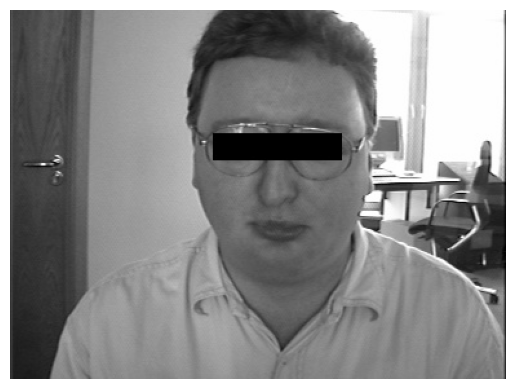

In [130]:
from matplotlib import pyplot as plt
img = cv2.imread("/content/drive/MyDrive/SafeAI/boxed_holdout/boxed_BioID_0134.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [131]:
torch.save(model.state_dict(), "/content/drive/MyDrive/SafeAI/eye_cnn.pth")

In [100]:
# 불러오기

# model = EyeCNN()
# model.load_state_dict(torch.load("eye_cnn.pth"))
# model.eval()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [101]:
!pip install retina-face opencv-python-headless

In [132]:
import os
import cv2
import numpy as np
from retinaface import RetinaFace

def compare_eye_coords(input_dir):
    files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(".pgm")])
    success_count = 0
    fail_count = 0

    mae_list, mse_list, euclidean_list = [], [], []
    data_pairs = []

    def read_eye_file(eye_path):
        try:
            with open(eye_path, 'r') as f:
                lines = f.readlines()
                if len(lines) < 2:
                    return None
                values = lines[1].strip().split()
                if len(values) != 4:
                    return None
                lx, ly, rx, ry = map(int, values)
                return (lx, ly), (rx, ry)
        except Exception as e:
            print(f"file error: {eye_path} - {e}")
            return None

    print("filename\tGT_L\tGT_R\tPR_L\tPR_R\tL_error\tR_error")

    for filename in files:
        image_path = os.path.join(input_dir, filename)
        eye_path = image_path.replace(".pgm", ".eye")

        gt_coords = read_eye_file(eye_path)
        gt_left, gt_right = gt_coords

        gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

        try:
            faces = RetinaFace.detect_faces(rgb)
            if not faces:
                print(f"No face: {filename}")
                fail_count += 1
                continue

            face = list(faces.values())[0]
            landmarks = face["landmarks"]
            pr_left = landmarks["left_eye"]
            pr_right = landmarks["right_eye"]

            l_error = round(np.linalg.norm(np.array(gt_left) - np.array(pr_left)), 2)
            r_error = round(np.linalg.norm(np.array(gt_right) - np.array(pr_right)), 2)

            print(f"{filename}\t{gt_left}\t{gt_right}\t{pr_left}\t{pr_right}\t{l_error}\t{r_error}")
            success_count += 1

            # 전체 지표를 위한 누적
            gt = np.array([*gt_left, *gt_right])
            pr = np.array([*pr_left, *pr_right])
            data_pairs.append((gt, pr))

        except Exception as e:
            print(f"Exception Error: {filename} - {type(e).__name__}: {e}")
            fail_count += 1

    # 📊 SOTA 지표 계산
    for gt, pr in data_pairs:
        diff = gt - pr
        mae = np.mean(np.abs(diff))
        mse = np.mean(diff ** 2)
        euclidean = np.linalg.norm(diff)

        mae_list.append(mae)
        mse_list.append(mse)
        euclidean_list.append(euclidean)

    print(f"\nMAE: {np.mean(mae_list):.2f}")
    print(f"MSE: {np.mean(mse_list):.2f}")
    print(f"Euclidean: {np.mean(euclidean_list):.2f}")

In [133]:
compare_eye_coords("/content/drive/MyDrive/SafeAI/comparisons")

filename	GT_L	GT_R	PR_L	PR_R	L_error	R_error
BioID_0140.pgm	(243, 119)	(179, 116)	[np.float32(239.53946), np.float32(114.65381)]	[np.float32(178.13518), np.float32(114.47114)]	5.56	1.76
BioID_0207.pgm	(242, 113)	(177, 112)	[np.float32(241.50998), np.float32(110.82748)]	[np.float32(179.08981), np.float32(111.001785)]	2.23	2.32
BioID_0211.pgm	(232, 115)	(167, 112)	[np.float32(229.87245), np.float32(112.67509)]	[np.float32(167.9954), np.float32(109.987915)]	3.15	2.24
BioID_0250.pgm	(259, 113)	(208, 111)	[np.float32(260.0051), np.float32(112.56578)]	[np.float32(208.38177), np.float32(109.92682)]	1.09	1.14
BioID_0331.pgm	(204, 145)	(160, 142)	[np.float32(201.7934), np.float32(144.59041)]	[np.float32(157.7959), np.float32(142.94089)]	2.24	2.4
BioID_0400.pgm	(164, 100)	(119, 98)	[np.float32(162.13423), np.float32(100.43073)]	[np.float32(117.47988), np.float32(99.757996)]	1.91	2.32
BioID_0446.pgm	(179, 100)	(119, 99)	[np.float32(180.51622), np.float32(101.72968)]	[np.float32(117.768814), np.fl